In [21]:
#Import everything
import pandas as pd
import h5py
import cartopy
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import csv
import powerlaw
import os
from datetime import datetime



## combine all year files into a single file:

In [5]:
data_loc='/Users/ellenbuckley/Documents/Analysis/FSD/IFTdata_Fram/all_floes/'

In [6]:
flist=[a for a in os.listdir('/Users/ellenbuckley/Documents/Analysis/FSD/IFTdata_Fram/all_floes/') if a.startswith('ift_clean')]
df= pd.DataFrame(columns=pd.read_csv('/Users/ellenbuckley/Documents/Analysis/FSD/IFTdata_Fram/all_floes/'+flist[0]).columns)
for fname in flist:
    df_temp=pd.read_csv(data_loc+fname)
    df=pd.concat([df,df_temp])

/var/folders/d9/yt5cny_52dg1hlsrpkcxnydr0000gp/T/ipykernel_6894/1673462139.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df=pd.concat([df,df_temp])


In [7]:

df=df.reset_index()
df['perim_km']=df.perimeter*.25
df['area_km']=df.area*.25*.25
df['circ']=( (4*np.pi * df['area_km'])/(df['perim_km']**2))
df['doy']=[int(datetime.fromisoformat(a).strftime('%j')) for a in df.datetime.values]
df['year']=[int(datetime.fromisoformat(a).strftime('%Y')) for a in df.datetime.values]

df.to_csv(data_loc+'df_allfloes.csv')

In [8]:
df=pd.read_csv(data_loc+'df_allfloes.csv')

## check data
##### check number of floes per year, floes size range each year, number of tracked floes, distribution of floes over time in each year

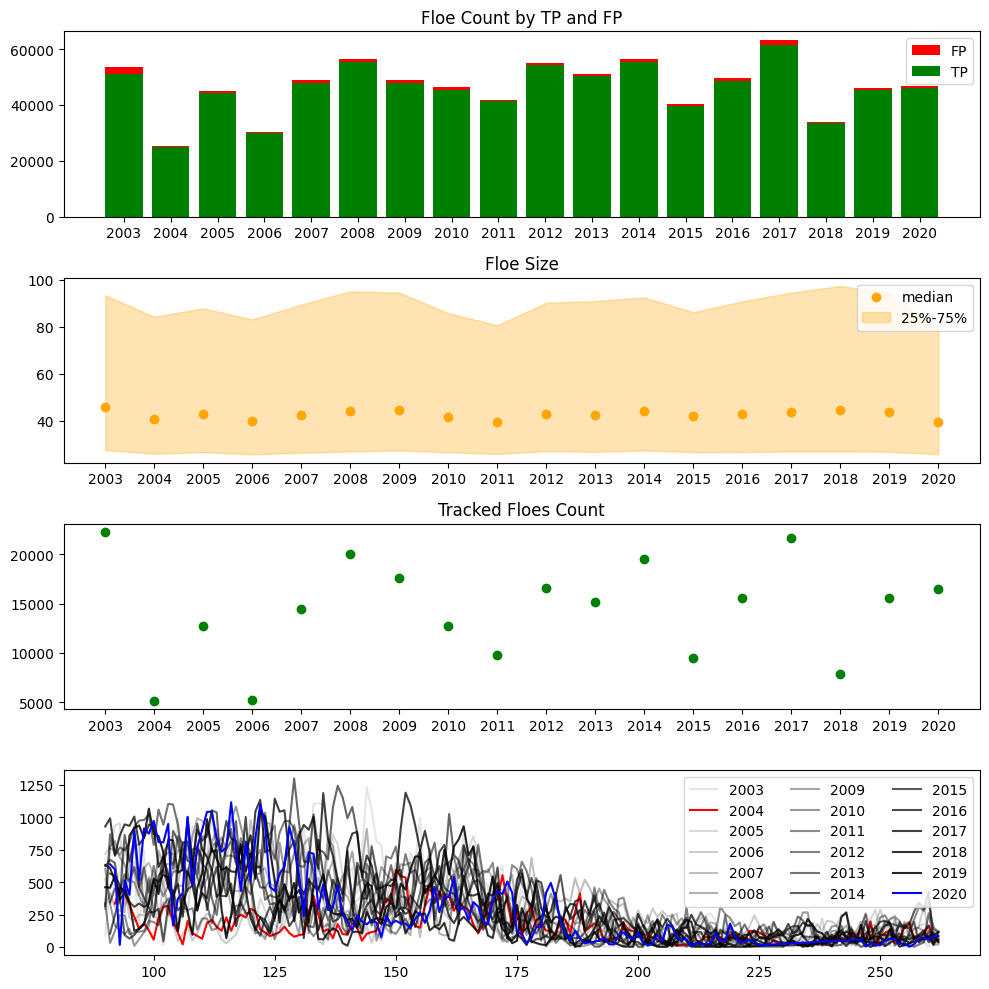

In [9]:
fig,ax=plt.subplots(4,1,figsize=(10,10))
for i in np.arange(0,3):
    ax[i].set_xticks(np.arange(2003,2021),[str(v) for v in np.arange(2003,2021)])

ax[0].bar(df[df.lr_classification==True].groupby(['year']).count().index,df[df.lr_classification==True].groupby(['year']).count().floe_id+df[df.lr_classification==False].groupby(['year']).count().floe_id,color='red',label='FP')
ax[0].bar(df[df.lr_classification==True].groupby(['year']).count().index,df[df.lr_classification==True].groupby(['year']).count().floe_id,color='green',label='TP')
ax[0].set_title('Floe Count by TP and FP')
ax[0].legend()
ax[1].scatter(df[['year','area_km']].groupby(['year']).median().index,df[['year','area_km']].groupby(['year']).median().area_km,c='orange',label='median')
ax[1].fill_between(df[['year','area_km']].groupby(['year']).mean().index,df[['year','area_km']].groupby(['year']).quantile(.25).area_km,df[['year','area_km']].groupby(['year']).quantile(.75).area_km,alpha=0.3,color='orange',label='25%-75%')
ax[1].set_title('Floe Size')
ax[1].legend()
for y in np.arange(2003,2021):
    ax[2].scatter(y,len(df[(df.year==y)&(df.floe_id!='unmatched')]),c='g')
ax[2].set_title('Tracked Floes Count')
alph=0.1
for y in np.arange(2003,2021):
    if y==2004:
        ax[3].plot(df[(df.year==2004)].groupby(['doy']).count().index,df[(df.year==2004)].groupby(['doy']).count().floe_id,alpha=1,c='r',label='2004')
    elif y==2020:
        ax[3].plot(df[(df.year==2020)].groupby(['doy']).count().index,df[(df.year==2020)].groupby(['doy']).count().floe_id,alpha=1,c='b',label='2020')
    else:
        ax[3].plot(df[(df.year==y)].groupby(['doy']).count().index,df[(df.year==y)].groupby(['doy']).count().floe_id,alpha=alph,c='k',label=str(y))
        alph+=.05

ax[3].legend(ncol=3)
plt.tight_layout()



# FSD plots

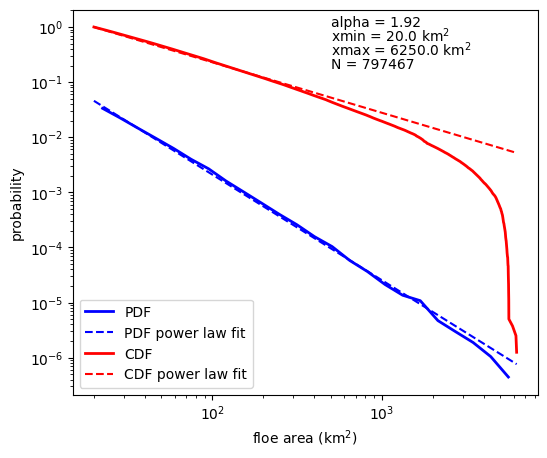

In [10]:
## all floes
data=df.area_km
fit = powerlaw.Fit(data,xmin=20)
fig2,ax=plt.subplots(1,1,figsize=(6,5))
fig2 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', ax=fig2, linestyle='--')
fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)
fig2.set_xlabel('floe area (km$^2$)')
fig2.set_ylabel('probability')
plt.text(500,1,'alpha = '+str(np.round(fit.power_law.alpha,2)))
plt.text(500,.55,'xmin = '+str(fit.xmin)+' km$^2$')
plt.text(500,.3,'xmax = '+str(np.round(np.amax(data),0))+' km$^2$')
plt.text(500,.18,'N = '+str(len(df[df.area_km>fit.xmin])))
plt.legend(['PDF','PDF power law fit','CDF','CDF power law fit'],loc=3)

plt.savefig(data_loc+'/figs/PDF_CDF_alldata.png')

## sea ice concentration

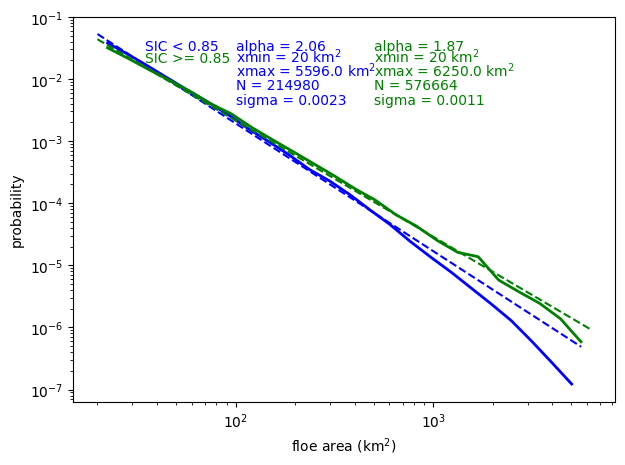

In [11]:
df=df[df.nsidc_sic<=1]
sp=0.85
xmin=20

data=df.area_km[(df.nsidc_sic<sp)]
data2=df.area_km[(df.nsidc_sic>=sp)]

fit = powerlaw.Fit(data,xmin=xmin)
fig,ax=plt.subplots(1,1,figsize=(7,5))
fig = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', ax=fig, linestyle='--')

fit2 = powerlaw.Fit(data2,xmin=xmin)

fit2.plot_pdf(color='g', ax=fig, linewidth=2)
fit2.power_law.plot_pdf(color='g', ax=fig, linestyle='--')

fig.set_xlabel('floe area (km$^2$)')
fig.set_ylabel('probability')
plt.text(100,.029,'alpha = '+str(np.round(fit.power_law.alpha,2)),color='b')
plt.text(100,.019,'xmin = '+str(xmin)+' km$^2$',color='b')
plt.text(100,.011,'xmax = '+str(np.round(np.amax(data),0))+' km$^2$',color='b')
plt.text(100,.007,'N = '+str(len(data[(data>xmin)])),color='b')
plt.text(100,.004,'sigma = '+str(np.round(fit.sigma,4)),color='b')

plt.text(500,.029,'alpha = '+str(np.round(fit2.power_law.alpha,2)),color='g')
plt.text(500,.019,'xmin = '+str(xmin)+' km$^2$',color='g')
plt.text(500,.011,'xmax = '+str(np.round(np.amax(data2),0))+' km$^2$',color='g')
plt.text(500,.007,'N = '+str(len(data2[(data2>xmin)])),color='g')
plt.text(500,.004,'sigma = '+str(np.round(fit2.sigma,4)),color='g')

plt.text(35,.029,'SIC < ' +str(sp),color='b')
plt.text(35,.019,'SIC >= ' +str(sp),color='g')

plt.savefig(data_loc+'/figs/PDF_SIC.png')

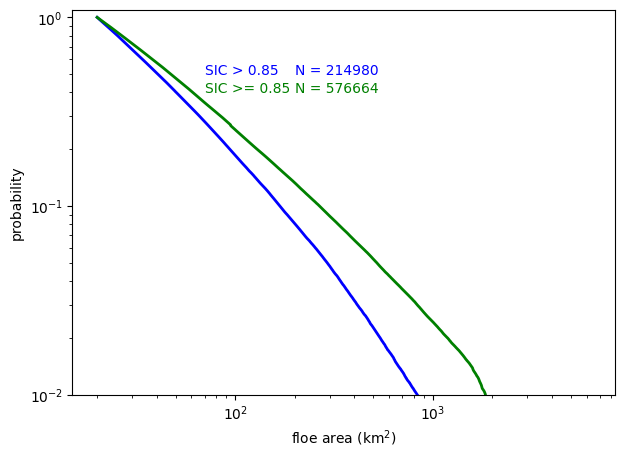

In [12]:

xmin=20

data=df.area_km[(df.nsidc_sic<sp)]
data2=df.area_km[(df.nsidc_sic>=sp)]

fit = powerlaw.Fit(data,xmin=xmin)
fig,ax=plt.subplots(1,1,figsize=(7,5))
fig = fit.plot_ccdf(color='b', linewidth=2)

fit2 = powerlaw.Fit(data2,xmin=xmin)

fit2.plot_ccdf(color='g', ax=fig, linewidth=2)

fig.set_xlabel('floe area (km$^2$)')
fig.set_ylabel('probability')

plt.text(200,.5,'N = '+str(len(data[(data>xmin)])),color='b')


plt.text(200,.4,'N = '+str(len(data2[(data2>xmin)])),color='g')
plt.ylim(1e-2,1.1)
plt.text(70,.5,'SIC > '+str(sp),color='b')
plt.text(70,.4,'SIC >= '+str(sp),color='g')

plt.savefig(data_loc+'/CCDF_SIC.png')

### notes on SIC
It's clear there is a difference in the floe size of floes in high SIC ( >=85% ) compared to those in low SIC. For high SIC conditions, there are larger floes (Figures, green) as seen in the separation of the cumulative distribution at large floes values, and also represented in the PDF with a smaller alpha value indicating a less steep slope due to the presence of larger floes in high SIC areas. The sigma on both of these fits is low such that the alpha values do not overlap with 2 sigma.

## month

In [13]:
# april 91-120
# july 181-212
#aug 213-243
# september 244-273

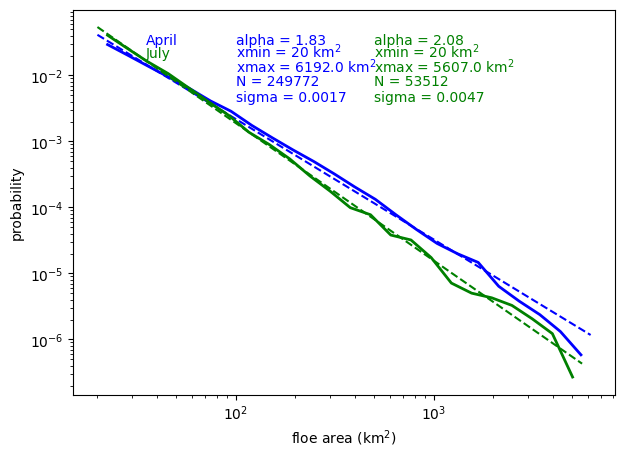

In [14]:
xmin=20

data=df.area_km[(df.doy<120)&(df.doy>91)] # april
data2=df.area_km[(df.doy<212)&(df.doy>181)] #vs. july

fit = powerlaw.Fit(data,xmin=xmin)
fig,ax=plt.subplots(1,1,figsize=(7,5))
fig = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', ax=fig, linestyle='--')

fit2 = powerlaw.Fit(data2,xmin=xmin)

fit2.plot_pdf(color='g', ax=fig, linewidth=2)
fit2.power_law.plot_pdf(color='g', ax=fig, linestyle='--')

fig.set_xlabel('floe area (km$^2$)')
fig.set_ylabel('probability')
plt.text(100,.029,'alpha = '+str(np.round(fit.power_law.alpha,2)),color='b')
plt.text(100,.019,'xmin = '+str(xmin)+' km$^2$',color='b')
plt.text(100,.011,'xmax = '+str(np.round(np.amax(data),0))+' km$^2$',color='b')
plt.text(100,.007,'N = '+str(len(data[(data>xmin)])),color='b')
plt.text(100,.004,'sigma = '+str(np.round(fit.sigma,4)),color='b')

plt.text(500,.029,'alpha = '+str(np.round(fit2.power_law.alpha,2)),color='g')
plt.text(500,.019,'xmin = '+str(xmin)+' km$^2$',color='g')
plt.text(500,.011,'xmax = '+str(np.round(np.amax(data2),0))+' km$^2$',color='g')
plt.text(500,.007,'N = '+str(len(data2[(data2>xmin)])),color='g')
plt.text(500,.004,'sigma = '+str(np.round(fit2.sigma,4)),color='g')

plt.text(35,.029,'April',color='b')
plt.text(35,.019,'July' ,color='g')
plt.savefig(data_loc+'/figs/PDF_AprilvJuly.png')

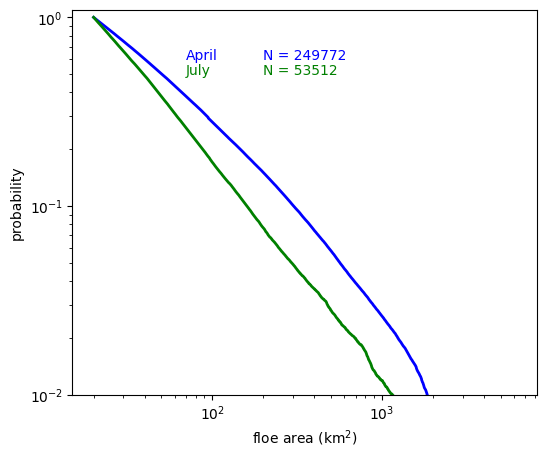

In [15]:

xmin=20

data=df.area_km[(df.doy<120)&(df.doy>91)] # april
data2=df.area_km[(df.doy<212)&(df.doy>181)] #vs. july

fit = powerlaw.Fit(data,xmin=xmin)
fig,ax=plt.subplots(1,1,figsize=(6,5))
fig = fit.plot_ccdf(color='b', linewidth=2)


fit2 = powerlaw.Fit(data2,xmin=xmin)

fit2.plot_ccdf(color='g', ax=fig, linewidth=2)

fig.set_xlabel('floe area (km$^2$)')
fig.set_ylabel('probability')

plt.text(200,.6,'N = '+str(len(data[(data>xmin)])),color='b')
plt.text(200,.5,'N = '+str(len(data2[(data2>xmin)])),color='g')
plt.ylim(1e-2,1.1)
plt.text(70,.6,'April',color='b')
plt.text(70,.5,'July',color='g')


plt.savefig(data_loc+'/figs/CCDF_AprilvJul.png')

In [16]:
## 

#### notes on seasonal difference:

There is also a difference between April v. July floe size distribution. At the end of winter in April, the floes are large and have not fractured and melted as much as then have in July. The floes in April are generally larger than those in July as seen in both the PDF and CDF.

## mapping average floe size

In [17]:
df.columns

Index(['Unnamed: 0.1', 'index', 'Unnamed: 0', 'datetime', 'satellite',
       'floe_id', 'label', 'longitude', 'latitude', 'x_stere', 'y_stere',
       'col_pixel', 'row_pixel', 'area', 'perimeter', 'solidity',
       'orientation', 'circularity', 'axis_major_length', 'axis_minor_length',
       'bbox_min_row', 'bbox_min_col', 'bbox_max_row', 'bbox_max_col',
       'area_matlab', 'perimeter_matlab', 'solidity_matlab',
       'orientation_matlab', 'nsidc_sic', 'theta_aqua', 'theta_terra',
       'tc_channel0', 'tc_channel1', 'tc_channel2', 'fc_channel0',
       'fc_channel1', 'fc_channel2', 'init_classification', 'lr_probability',
       'lr_classification', 'perim_km', 'area_km', 'circ', 'doy', 'year'],
      dtype='object')

In [18]:
x=df.longitude
y=df.latitude
xi, yi = np.mgrid[-34:30:1,68:88:1]
xbins=np.arange(-34,30,1)
ybins=np.arange(68,88,1)
dens,_,_=np.histogram2d(x,y,[xbins,ybins])

In [22]:
f=np.zeros((np.shape(xi)[0]-1,np.shape(xi)[1]-1))
for i in np.arange(0,len(xbins)-1):
    for j in np.arange(0,len(ybins)-1):
        df_temp=df[(df.longitude>xbins[i])&(df.longitude<xbins[i+1])&(df.latitude>ybins[j])&(df.latitude<ybins[j+1])]#&(df.doy>120)&(df.doy<152)]
        f[i,j]=np.median(df_temp.area_km)

/Users/ellenbuckley/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ellenbuckley/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


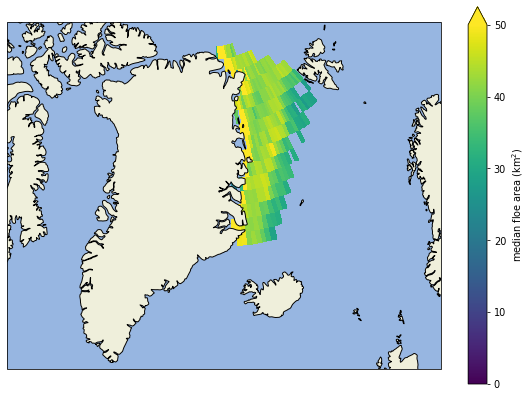

In [24]:
plt.figure(figsize=(10,10), dpi= 70)

ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70,central_longitude=-30))
#ax.set_boundary(circle, transform=ax.transAxes)
f[dens<=200]=np.nan
ax.coastlines(zorder=0)
ax.add_feature(cartopy.feature.OCEAN)
b=ax.pcolormesh(xi, yi, f,vmin=0,vmax=50,transform=ccrs.PlateCarree(),zorder=-1)

ax.add_feature(cartopy.feature.LAND)

ax.set_extent([-60, 5, 85, 60], ccrs.PlateCarree())
plt.colorbar(b, ax=ax,label='median floe area (km$^2$)', shrink=0.7, extend='max')
plt.savefig(data_loc+'/figs/median_floe_area_map.png')

### notes on location of floes:
The largest floes are located near the Greenland continent. This could be because there are many floes in this area that are broken off landfast ice. Or the floes farther from the ice edge are move susceptible to break up from ocean waves.